<a href="https://colab.research.google.com/github/aviax1/AE1/blob/master/model128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**dependencies**

In [ ]:
!pip install wandb

In [2]:
import torch,wandb,os,warnings,csv
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from tensorflow.keras.datasets import mnist
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**initial**

In [3]:
(xtrain,ytrain), (xtest,ytest) = mnist.load_data()
num_epochs=1000        #
batch_size = 64        #
image_size=784         #
hidden_size=128         #
lv_size = 48           # Latent Variable 
learning_rate=1e-4     #
cret = nn.MSELoss()    # criterion
warnings.filterwarnings('ignore')

11493376/11490434 [==============================] - 0s 0us/step


**build model**

In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, hidden_size), 
            nn.ReLU(True), nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True), nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True), nn.Linear(hidden_size, hidden_size),
             nn.ReLU(True), nn.Linear(hidden_size, lv_size))
        self.decoder = nn.Sequential(
            nn.Linear(lv_size, hidden_size),nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),nn.ReLU(True),
             nn.Linear(hidden_size, image_size), nn.Tanh())

    def forward(self, x):
        return self.decoder(self.encoder(x))

**model setting**

In [5]:
model = autoencoder()
tmodel=autoencoder()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

class DigitDataSet(Dataset):
  def __init__(self, dataset):
      self.dataset = dataset
      self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

  def __len__(self):
      return len(self.dataset)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()
      return self.transform( self.dataset[idx,:,:])

**classsifcation by train models**

In [6]:
def model_name(digit):
  return './ae_'+str(digit)+'.pth'

def get_prediction(data=xtest):
  nn=len(data)
  dataloader = DataLoader(DigitDataSet(data), batch_size=nn,shuffle=0 , num_workers=4)
  diff = np.zeros( (nn,10),dtype=np.float32 )
  for i in range(10):
    for data in dataloader:
      input_imgs = data
      imgs = Variable(input_imgs.view(input_imgs.size(0), -1))
      tmodel.load_state_dict(torch.load(model_name(i)))
      tmodel.eval()
      output_imgs = tmodel(imgs)
      for i2 in range(len( output_imgs[:,0])):
        im_pred=output_imgs.detach().numpy()[i2,:]
        im_org=imgs.numpy()[i2,:]
        difmat=np.abs(im_pred.reshape(28,28)-im_org.reshape(28,28))
        diff[i2,i]=np.sum( np.sum( difmat ))
  return np.argmin(diff, axis=1)


def testmodel(): 
  nn=len(ytest)
  min_index =get_prediction()
  seccess =  min_index == ytest
  counts, bins = np.histogram(ytest[ min_index != ytest ])
  plt.hist(bins[:-1], bins, weights=counts)
  plt.title("error by digit")
  plt.show()
  accurcy =int(10000*np.sum(seccess))/(nn*100)
  error_rate = int(10000*np.sum(min_index != ytest))/(nn*100)
  print(str(accurcy) + "% accuracy or "+str(error_rate)+"% error rate")
  return counts, bins ,len(ytest[min_index != ytest]) , len(ytest)

**train method**

In [7]:
def save_model(digit,model):
  mn=model_name(digit)
  torch.save(model.state_dict(),mn )
  wandb.save(mn)
  print("save model "+ mn)

def load_model_ifexist(digit,model):
  mn=model_name(digit)
  if os.path.isfile(mn):
    model.load_state_dict(torch.load(mn))
    model.eval()
  return model

def train_by_digit(by_digit,model,ne=num_epochs,opt=optimizer):
  model=load_model_ifexist( by_digit,model)
  wandb.init()
  print("*****\nstart traning Model for digit " +str(by_digit) +"\n")
  dataloader = DataLoader(DigitDataSet(xtrain[ytrain==by_digit]), batch_size=batch_size,shuffle=True, num_workers=6)
  minloss=100000000
  for epoch in range(ne):
    run=  epoch%25==0
    run2= epoch%125==0 and epoch >0
    for data in dataloader:
      imgs = Variable(data.view(data.size(0), -1))
      output_imgs = model(imgs)
      loss = cret(output_imgs, imgs)
      if minloss!=100000000:
        opt.zero_grad()
        loss.backward()
        opt.step()
      if run:
        run=0
        im=data[0,0,:,:].reshape(28,28)
        pred=model(imgs).detach().numpy()[0,:].reshape(28,28)
        wandb.log({"img": [wandb.Image(pred, caption="preidciton"),wandb.Image(im, caption="original")]})
      if run2:
        run2=0
        save_model(by_digit,model)
        testmodel()
    newlost = float(loss.data ) 
    if newlost < minloss:
        if minloss!=100000000:
          save_model(by_digit,model)
        minloss=newlost
    print('epoch [{}/{}], loss:{:.4f}' .format(epoch + 1, ne, loss.data))
    wandb.log({"loss": loss.data})
  
  print("\nfinish traning Model Number " +str(by_digit) +"\n*****\n")

**train new model**

In [ ]:
for i in range(by_digit):
  train_by_digit(by_digit,model,30)
_,_,_,_=testmodel()

**or used our train model**

In [ ]:
!git clone https://github.com/aviax1/AE1/
!unzip ./AE1/models.zip -d ./
!rm -rf ./AE1

**finaly test model and save it**

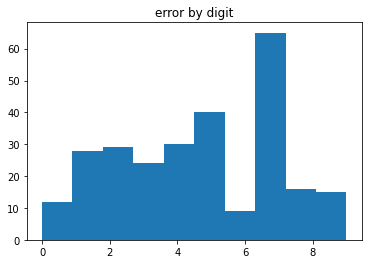

97.32% accuracy or 2.68% error rate


In [18]:
_,_,_,_=testmodel()

**save the model**

In [19]:
!zip -r model.zip ./*.pth

updating: ae_0.pth (deflated 6%)
updating: ae_1.pth (deflated 5%)
updating: ae_2.pth (deflated 6%)
updating: ae_3.pth (deflated 7%)
updating: ae_4.pth (deflated 8%)
updating: ae_5.pth (deflated 7%)
updating: ae_6.pth (deflated 9%)
updating: ae_7.pth (deflated 10%)
updating: ae_8.pth (deflated 10%)
updating: ae_9.pth (deflated 10%)


**retrain the model**

In [ ]:
traget_error=0.005
error = 1
while  error > traget_error:
  counts,b,fail,total=testmodel()
  error = float(fail/total)
  if error > traget_error:
    train_by_digit(np.argmax(counts),model,30, torch.optim.Adam(model.parameters(), lr=1e-3) )

**kaggle**

In [ ]:
!git clone https://github.com/aviax1/AE1/
!unzip ./AE1/kaggle.zip -d ./
!rm -rf ./AE1

In [ ]:
inputs_test=pd.read_csv('./test.csv')
inputs_test=np.array(inputs_test,dtype=np.float32)
inputs_test=inputs_test.reshape(inputs_test.shape[0],28,28)/255
y=get_prediction(inputs_test)
imageid=1
with open('submission.csv', 'w', newline='') as csvfile:
  spamwriter = csv.writer(csvfile, delimiter=' ',    quotechar='|', quoting=csv.QUOTE_MINIMAL)
  spamwriter.writerow(['ImageId,Label'])
  for yi in y:
    spamwriter.writerow([str(imageid) +','+str( yi)])
    imageid+=1
#99.714% accuracy